```
Copyright 2022 Google LLC.

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
```


# SE3DS RealEstate10K Example Colab

[Paper](https://arxiv.org/abs/2204.02960) | [Video](https://www.youtube.com/watch?v=lhwwlrRfFp0)

This Colab demonstrates how to load and use an SE3DS model pretrained on the RealEstate10K dataset. This is part of the code for the paper "Simple and Effective Synthesis for 3D Scenes". The full codebase is found at https://github.com/google-research/se3ds/.

It is recommended that you run this Colab with a **GPU runtime**. You might get a warning about file space, but it will be resolved after the checkpoint is extracted / un-tarred.

## Download code, model weights, and install dependencies

In [1]:
%%shell
echo
svn export --force https://github.com/google-research/se3ds/trunk se3ds
echo Installing required dependencies.
pip install -r se3ds/colab_requirements.txt

echo
echo Fetching trained model weights...
mkdir data
rm -f data/ckpt.tar
rm -rf data/ckpt/
wget https://storage.googleapis.com/gresearch/se3ds/re10k_ckpt.tar -P data/
echo Extracting model weights...
tar -xf data/re10k_ckpt.tar --directory data/
rm data/re10k_ckpt.tar
echo Done.


Cloning into 'se3ds'...
remote: Enumerating objects: 78, done.
remote: Counting objects: 100% (78/78), done.
remote: Compressing objects: 100% (58/58), done.
remote: Total 78 (delta 25), reused 72 (delta 19), pack-reused 0
Unpacking objects: 100% (78/78), done.
Installing required dependencies.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 164 kB 5.3 MB/s 
     |████████████████████████████████| 4.1 MB 63.0 MB/s 
     |████████████████████████████████| 61 kB 9.4 MB/s 
     |████████████████████████████████| 1.1 MB 55.9 MB/s 
     |████████████████████████████████| 62 kB 1.5 MB/s 
     |████████████████████████████████| 38.1 MB 1.2 MB/s 
     |████████████████████████████████| 1.1 MB 52.5 MB/s 
     |████████████████████████████████| 138 kB 70.8 MB/s 
     |████████████████████████████████| 224 kB 50.9 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uni

## Imports and utils

In [8]:
import time
import tensorflow as tf
import math
import collections
import numpy as np
import os
from matplotlib import animation, rc
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.spatial.transform import Rotation as R

from se3ds import constants
from se3ds.models import model_config
from se3ds.models import models
from se3ds.utils import utils
from se3ds.utils import pano_utils

devices = tf.config.experimental.list_logical_devices(device_type="GPU")
print([d.name for d in devices])
strategy = tf.distribute.MirroredStrategy(devices)

['/device:GPU:0']
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


## Data

Load an example perspective image.

In [3]:
%%bash
wget --no-check-certificate https://storage.googleapis.com/gresearch/se3ds/example_perspective.tar -P data/
tar -xf data/example_perspective.tar --directory data/

--2022-06-30 18:56:39--  https://storage.googleapis.com/gresearch/se3ds/example_perspective.tar
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.13.128, 172.217.193.128, 172.217.204.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.13.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1617920 (1.5M) [application/x-tar]
Saving to: ‘data/example_perspective.tar’

     0K .......... .......... .......... .......... ..........  3% 57.5M 0s
    50K .......... .......... .......... .......... ..........  6% 81.7M 0s
   100K .......... .......... .......... .......... ..........  9% 53.0M 0s
   150K .......... .......... .......... .......... .......... 12% 25.8M 0s
   200K .......... .......... .......... .......... .......... 15% 25.2M 0s
   250K .......... .......... .......... .......... .......... 18% 25.3M 0s
   300K .......... .......... .......... .......... .......... 22% 21.1M 0s
   350K .......... .........

Preprocess images.

In [4]:
equirectangular_height = 1024
pers_height, pers_width = 256, 256

# Camera intrinsics matrix.
camera_intrinsics = np.array(
    [[[128.,   0., 128.],
      [  0., 128., 128.],
      [  0.,   0.,   1.]]], np.float32
)
# Original camera rotation matrix (e.g., from COLMAP).
rot_mat = np.array(
    [[[0.99992853, -0.01185191,  0.00158339],
      [0.01187317,  0.9998291,  -0.01416931],
      [-0.00141519,  0.01418709,  0.9998984 ]]],  np.float32
)
# Scaling/bias factor for MiDaS depth (e.g., from COLMAP).
scaling_factor = 5
bias_factor = 0.0

# Load an example pano.
base_dir = 'data/'
with tf.io.gfile.GFile(os.path.join(base_dir, 're10k_rgb.png'), 'rb') as f:
  input_rgb_frames = tf.image.decode_jpeg(f.read())
  input_rgb_frames = tf.image.resize(input_rgb_frames, (pers_height, pers_width), method='bilinear')
  input_rgb_frames = tf.cast(input_rgb_frames, tf.uint8)
with tf.io.gfile.GFile(os.path.join(base_dir, 're10k_depth.png'), 'rb') as f:
  input_depth_frames = tf.image.decode_png(f.read(), dtype=tf.uint16)
  input_depth_frames = tf.image.convert_image_dtype(input_depth_frames, tf.float32)
  input_depth_frames = tf.image.resize(input_depth_frames, (pers_height, pers_width), method='nearest')

  # Depth is inverted for MiDaS.
  midas_max = tf.reduce_max(input_depth_frames)
  input_depth_frames = midas_max - input_depth_frames
  input_depth_frames = input_depth_frames / midas_max / scaling_factor + bias_factor
  input_depth_frames = tf.clip_by_value(input_depth_frames, 0, 1)

# Format example into (batch_size, height, width, channels) format.
input_rgb_frames = input_rgb_frames[None, ...]   # (1, 256, 256, 3)
input_depth_frames = input_depth_frames[None, ..., 0]   # (1, 256, 256)

## Image Generation

Run inference with a pretrained model.

In [5]:
# Load a pretrained SE3DS model.
config = model_config.get_re10k_config()
config.ckpt_path = 'data/se3ds_re10k_ckpt'
stoch_model = models.SE3DSModel(config)

Restored from data/se3ds_re10k_ckpt


Accumulate RGB / depth into the point cloud.

In [6]:
rgb_tensor = pano_utils.project_perspective_image(
    tf.image.convert_image_dtype(input_rgb_frames[0, ...], tf.float32),
    None,
    equirectangular_height,
    camera_intrinsics=camera_intrinsics[0, ...],
    rotations=None,
    rotation_matrix=rot_mat[0, ...],
    round_to_nearest=True)

depth_tensor = pano_utils.project_perspective_image(
    tf.image.convert_image_dtype(input_depth_frames[0, ..., None], tf.float32),
    None,
    equirectangular_height,
    camera_intrinsics=camera_intrinsics[0, ...],
    rotations=None,
    rotation_matrix=rot_mat[0, ...],
    round_to_nearest=True)

proj_depth_tensor = depth_tensor[None, ..., 0]
proj_rgb_tensor = tf.cast(rgb_tensor[None, ...] * 255, tf.int32)

# Add points to point cloud memory.
xyz1, feats = pano_utils.equirectangular_to_pointcloud(
    proj_rgb_tensor, proj_depth_tensor,
    constants.INVALID_RGB_VALUE, constants.DEPTH_SCALE)

Generate images at a different position / rotation.

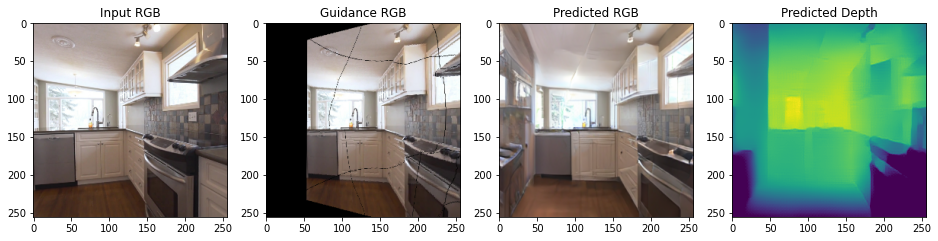

In [10]:
# Example translation vector and rotation.
translation_in_meters = 0.2 #@param {type:"number"}
tvec = [0, 0, translation_in_meters / constants.DEPTH_SCALE]
angle_in_degrees = 15 #@param {type:"number"}
angle = angle_in_degrees / 180 * np.pi
new_rotation = R.from_rotvec([0, angle, 0]).as_matrix()
new_rot_mat = rot_mat @ new_rotation

relative_position = tf.stack(
    [tvec[0], tvec[2], -tvec[1], tf.zeros(())], axis=-1)[None, :]
relative_coords = xyz1 - relative_position[..., None]

# project point-cloud to equirectangular.
pred_depth, pred_rgb = (
    pano_utils.project_feats_to_equirectangular(
        feats, relative_coords, equirectangular_height, equirectangular_height * 2,
        constants.INVALID_RGB_VALUE, constants.DEPTH_SCALE))

# convert into perspective images here:
pers_rgb_guidance = pano_utils.get_perspective_from_equirectangular_image(
    pred_rgb[0], camera_intrinsics[0, ...], new_rot_mat[0, ...], pers_height,
    pers_width)  # (H, W, 3)
pers_rgb_guidance = tf.clip_by_value(pers_rgb_guidance / 255, 0, 1)
pers_rgb_guidance = pers_rgb_guidance[None, ...]  # Add batch dimension

pers_depth_guidance = pano_utils.get_perspective_from_equirectangular_image(
    pred_depth[0][..., None], camera_intrinsics[0, ...], new_rot_mat[0, ...], pers_height,
    pers_width)  # (H, W, 1)
pers_depth_guidance = pers_depth_guidance[None, ...]  # Add batch dimension

pred_mask = tf.cast(
    tf.math.logical_and(
        tf.math.logical_and(pred_depth != 1.0, pred_depth != 0.0),
        tf.math.reduce_all(pred_rgb != 0.0, axis=-1),
        ), tf.float32)  # (1, H, W)

pred_mask = pano_utils.get_perspective_from_equirectangular_image(
    pred_mask[0][..., None], camera_intrinsics[0, ...], new_rot_mat[0, ...], pers_height,
    pers_width)  # (H, W, 1)
pred_mask = tf.cast(pred_mask[None, ...] == 1.0, tf.float32)  # Add batch dimension

blurred_mask = tf.zeros((1, pers_height, pers_width, 1))


inputs = {
    'proj_image': pred_mask * pers_rgb_guidance,
    'proj_depth': pred_mask * pers_depth_guidance,
    'proj_mask': pred_mask,
    'blurred_mask': blurred_mask,
}

(_, _, _, depth_out, _, _, rgb_out) = stoch_model.model(
    [inputs, None], training=False)

fig, ax = plt.subplots(1, 4, figsize=(16, 4))
ax[0].imshow(input_rgb_frames[0, ...] / 255)
ax[0].set_title("Input RGB")
ax[1].imshow(pers_rgb_guidance[0, ...])
ax[1].set_title("Guidance RGB")
ax[2].imshow(rgb_out[0, ...])
ax[2].set_title("Predicted RGB")
ax[3].imshow(depth_out[0, ..., 0])
ax[3].set_title("Predicted Depth")
plt.show()